# Reconnaissance Faciale avec CNN sur Dataset Fictif (Morphed)

Architecture exacte du projet Kaggle: https://www.kaggle.com/code/sifboudjellal/face-recognition-using-cnn

**Configuration:**
- 5 identités fictives (basées sur les dossiers de morphing)
- 80% des images pour l'entraînement, 20% pour le test
- Architecture CNN identique au projet Kaggle

## Step 1: Import Libraries

In [21]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
import itertools

import warnings
warnings.filterwarnings('ignore')

print(f"Keras version: {keras.__version__}")

Keras version: 3.13.2


## Step 2: Load Dataset

In [22]:
# Chemin vers le dataset
DATA_PATH = r"C:\Users\marwa\OneDrive\Desktop\lfw_morph_comparison"

# Taille des images (comme ORL: 112x92, mais on adapte)
im_rows = 112
im_cols = 92

# Lister les identités (dossiers)
identities = sorted([d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))])
num_classes = len(identities)

print(f"Nombre d'identités fictives: {num_classes}")
print(f"Identités: {identities}")

Nombre d'identités fictives: 5
Identités: ['morph_lfw_01_02', 'morph_lfw_03_04', 'morph_lfw_05_06', 'morph_lfw_07_08', 'morph_lfw_09_10']


In [23]:
def load_images_from_folder(folder_path, im_rows, im_cols):
    """
    Charge toutes les images d'un dossier en niveaux de gris et les redimensionne.
    """
    images = []
    
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            try:
                # Charger l'image en niveaux de gris
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Redimensionner
                    img = cv2.resize(img, (im_cols, im_rows))
                    images.append(img)
            except Exception as e:
                print(f"Erreur lors du chargement de {filename}: {e}")
    
    return images

# Charger toutes les images avec leurs labels
X = []
y = []

print("Chargement des images...")
for label, identity in enumerate(identities):
    folder_path = os.path.join(DATA_PATH, identity)
    images = load_images_from_folder(folder_path, im_rows, im_cols)
    
    X.extend(images)
    y.extend([label] * len(images))
    
    print(f"  {identity} (label={label}): {len(images)} images chargées")

X = np.array(X)
y = np.array(y)

print(f"\nTotal: {len(X)} images chargées")
print(f"Shape des images: {X.shape}")

Chargement des images...
  morph_lfw_01_02 (label=0): 50 images chargées
  morph_lfw_03_04 (label=1): 50 images chargées
  morph_lfw_05_06 (label=2): 50 images chargées
  morph_lfw_07_08 (label=3): 50 images chargées
  morph_lfw_09_10 (label=4): 50 images chargées

Total: 250 images chargées
Shape des images: (250, 112, 92)


In [24]:
# Normaliser les images (comme dans le projet Kaggle)
X = np.array(X, dtype='float32') / 255

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nExemple de données X:")
print(X[:3])

X shape: (250, 112, 92)
y shape: (250,)

Exemple de données X:
[[[0.4        0.36078432 0.33333334 ... 0.8        0.80784315 0.827451  ]
  [0.39215687 0.3529412  0.3254902  ... 0.8        0.80784315 0.827451  ]
  [0.35686275 0.3764706  0.3647059  ... 0.80784315 0.8117647  0.827451  ]
  ...
  [0.26666668 0.34901962 0.35686275 ... 0.79607844 0.69803923 0.24705882]
  [0.21568628 0.3254902  0.36078432 ... 0.78431374 0.6509804  0.22352941]
  [0.18431373 0.27450982 0.35686275 ... 0.7764706  0.6156863  0.2       ]]

 [[0.34901962 0.42745098 0.47843137 ... 0.84705883 0.8509804  0.8980392 ]
  [0.35686275 0.42745098 0.47058824 ... 0.8666667  0.85490197 0.90588236]
  [0.36862746 0.43137255 0.47843137 ... 0.8745098  0.8627451  0.92156863]
  ...
  [0.41960785 0.7921569  0.7647059  ... 0.5411765  0.68235296 0.9843137 ]
  [0.47843137 0.8039216  0.7529412  ... 0.52156866 0.76862746 0.99607843]
  [0.53333336 0.79607844 0.7372549  ... 0.54509807 0.8666667  0.99607843]]

 [[0.29411766 0.28235295 0.309803

## Step 3: Split Dataset (80% Train, 20% Test)

In [25]:
# Split train/test (80/20)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42,
    stratify=y  # Stratification pour équilibrer les classes
)

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train: {y_train}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (200, 112, 92)
x_test shape: (50, 112, 92)
y_train: [1 0 2 1 1 0 4 1 1 4 1 3 4 2 2 1 1 2 3 1 4 0 2 2 2 3 1 2 0 0 3 3 1 1 3 0 1
 1 2 1 4 1 2 2 3 3 2 4 1 0 3 0 4 3 0 0 0 2 3 0 0 1 0 1 4 2 0 2 4 1 0 4 4 3
 1 4 4 3 4 4 1 0 1 2 2 2 4 1 3 0 0 1 4 2 0 2 1 3 4 2 2 1 4 3 0 4 2 3 0 1 3
 4 2 1 0 1 3 0 0 0 3 1 1 3 1 2 0 2 0 3 3 0 0 1 2 0 0 2 2 4 4 3 3 3 4 0 3 0
 1 4 4 2 4 3 2 3 4 4 2 4 4 1 2 4 4 2 1 3 3 3 4 3 4 0 3 0 3 1 4 0 2 1 2 2 3
 0 2 1 3 3 4 4 0 3 2 2 0 3 4 4]
y_test shape: (50,)


In [26]:
# Créer un set de validation (5% du train, comme dans Kaggle)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, 
    test_size=0.05, 
    random_state=1234
)

print(f"Après split validation:")
print(f"x_train: {x_train.shape[0]} images")
print(f"x_valid: {x_valid.shape[0]} images")
print(f"x_test: {x_test.shape[0]} images")

Après split validation:
x_train: 190 images
x_valid: 10 images
x_test: 50 images


## Step 4: Reshape Images for CNN

In [27]:
# Paramètres
batch_size = 512
im_shape = (im_rows, im_cols, 1)  # 1 channel pour grayscale

# Reshape pour CNN (ajouter la dimension du channel)
x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_valid = x_valid.reshape(x_valid.shape[0], *im_shape)

print(f"x_train shape: {x_train.shape}")
print(f"x_valid shape: {x_valid.shape}")
print(f"x_test shape: {x_test.shape}")

x_train shape: (190, 112, 92, 1)
x_valid shape: (10, 112, 92, 1)
x_test shape: (50, 112, 92, 1)


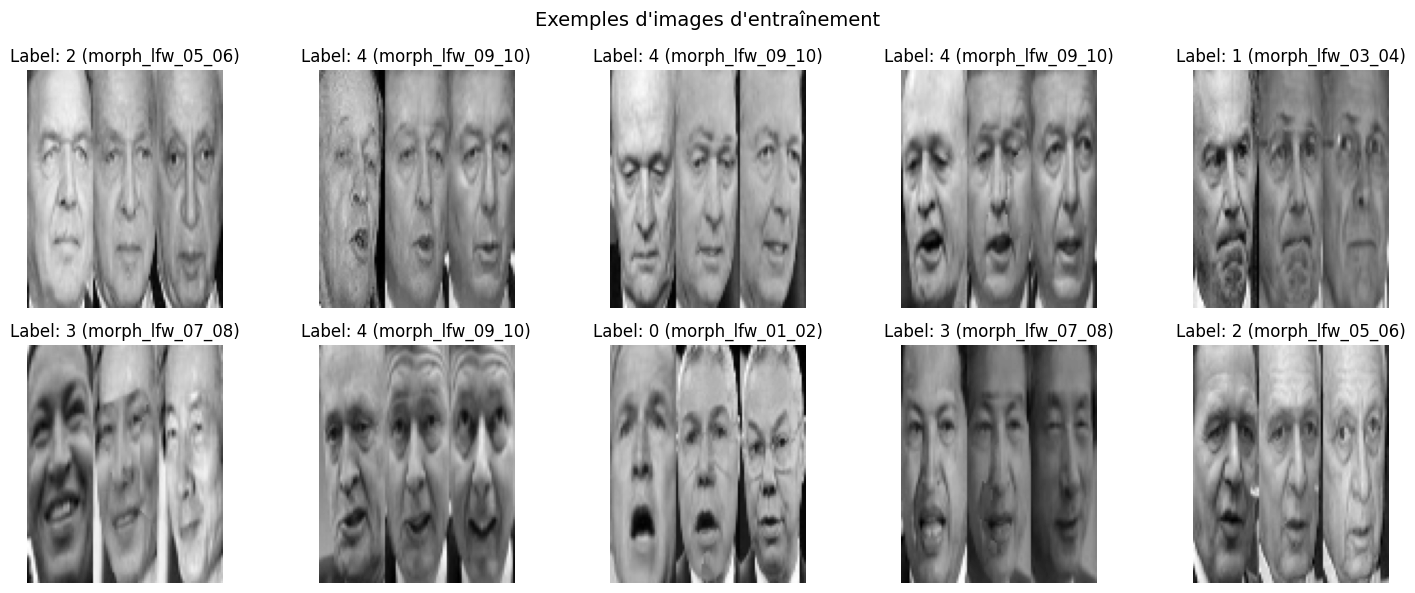

In [28]:
# Visualiser quelques exemples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    idx = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[idx].reshape(im_rows, im_cols), cmap='gray')
    axes[i].set_title(f"Label: {y_train[idx]} ({identities[y_train[idx]]})")
    axes[i].axis('off')

plt.suptitle('Exemples d\'images d\'entraînement', fontsize=14)
plt.tight_layout()
plt.show()

## Step 5: Build CNN Model (Architecture Kaggle exacte)

In [29]:
# Architecture EXACTE du projet Kaggle
cnn_model = Sequential([
    # Première couche conv: 36 filtres, kernel 7x7
    Conv2D(filters=36, kernel_size=7, activation='relu', input_shape=im_shape),
    MaxPooling2D(pool_size=2),
    
    # Deuxième couche conv: 54 filtres, kernel 5x5
    Conv2D(filters=54, kernel_size=5, activation='relu'),
    MaxPooling2D(pool_size=2),
    
    # Flatten
    Flatten(),
    
    # Fully connected layers
    Dense(2024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    # Output layer (nombre de classes = nombre d'identités)
    Dense(num_classes, activation='softmax')
])

# Compiler avec les mêmes paramètres que Kaggle
cnn_model.compile(
    loss='sparse_categorical_crossentropy',  # Pas besoin de one-hot encoding
    optimizer=Adam(learning_rate=0.0001),    # lr=0.0001 comme Kaggle
    metrics=['accuracy']
)

# Afficher le résumé
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 106, 86, 36)    │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 43, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 49, 39, 54)     │        48,654 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 19, 54)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 24624)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2024)           │    49,841,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,073,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,492,419 (200.24 MB)

 Trainable params: 52,492,419 (200.24 MB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Train the Model

In [30]:
# Entraînement avec les mêmes paramètres que Kaggle
EPOCHS = 250

print(f"Début de l'entraînement...")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: 0.0001")

history = cnn_model.fit(
    np.array(x_train), np.array(y_train),
    batch_size=batch_size,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(np.array(x_valid), np.array(y_valid))
)

Début de l'entraînement...
Epochs: 250
Batch size: 512
Learning rate: 0.0001
Epoch 1/250
1/1 - 8s - 8s/step - accuracy: 0.1316 - loss: 1.6265 - val_accuracy: 0.3000 - val_loss: 1.6024
Epoch 2/250
1/1 - 3s - 3s/step - accuracy: 0.2368 - loss: 1.6104 - val_accuracy: 0.1000 - val_loss: 1.6126
Epoch 3/250
1/1 - 3s - 3s/step - accuracy: 0.1895 - loss: 1.6258 - val_accuracy: 0.1000 - val_loss: 1.6146
Epoch 4/250
1/1 - 3s - 3s/step - accuracy: 0.1737 - loss: 1.6186 - val_accuracy: 0.1000 - val_loss: 1.6090
Epoch 5/250
1/1 - 3s - 3s/step - accuracy: 0.2421 - loss: 1.6117 - val_accuracy: 0.4000 - val_loss: 1.5941
Epoch 6/250
1/1 - 2s - 2s/step - accuracy: 0.2368 - loss: 1.6106 - val_accuracy: 0.4000 - val_loss: 1.5820
Epoch 7/250
1/1 - 2s - 2s/step - accuracy: 0.1737 - loss: 1.6508 - val_accuracy: 0.4000 - val_loss: 1.5812
Epoch 8/250
1/1 - 3s - 3s/step - accuracy: 0.2263 - loss: 1.6068 - val_accuracy: 0.3000 - val_loss: 1.5833
Epoch 9/250
1/1 - 3s - 3s/step - accuracy: 0.2316 - loss: 1.5957 - 

## Step 7: Evaluate the Model

In [31]:
# Évaluer sur le test set
score = cnn_model.evaluate(np.array(x_test), np.array(y_test), verbose=0)

print(f"\n{'='*50}")
print(f"RÉSULTATS SUR L'ENSEMBLE DE TEST")
print(f"{'='*50}")
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f} ({score[1]*100:.2f}%)')


RÉSULTATS SUR L'ENSEMBLE DE TEST
Test loss: 0.3831
Test accuracy: 0.9000 (90.00%)


## Step 8: Plot Training History

Données disponibles: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


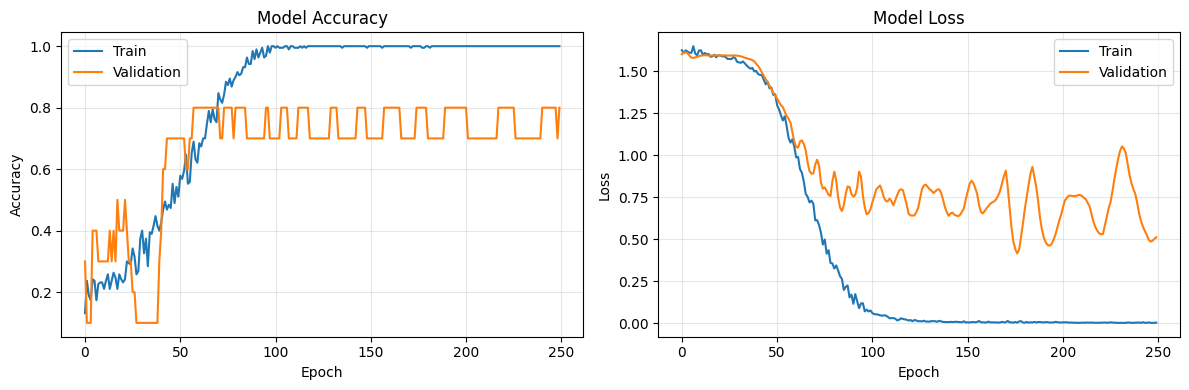

In [32]:
# Afficher les clés disponibles
print("Données disponibles:", history.history.keys())

# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 9: Confusion Matrix

In [33]:
# Prédictions
y_pred = np.argmax(cnn_model.predict(x_test), axis=-1)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)")

# Matrice de confusion
cnf_matrix = confusion_matrix(np.array(y_test), y_pred)
print(f"\nMatrice de confusion:")
print(cnf_matrix)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Accuracy: 0.9000 (90.00%)

Matrice de confusion:
[[ 8  0  0  1  1]
 [ 0  8  2  0  0]
 [ 1  0  9  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 10]]


In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

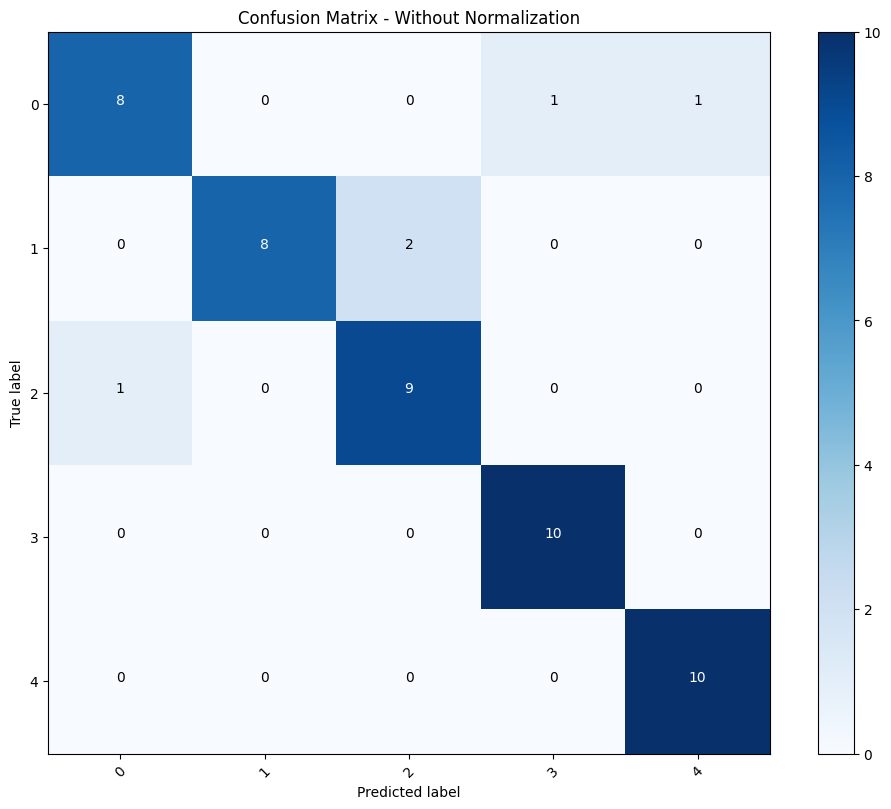

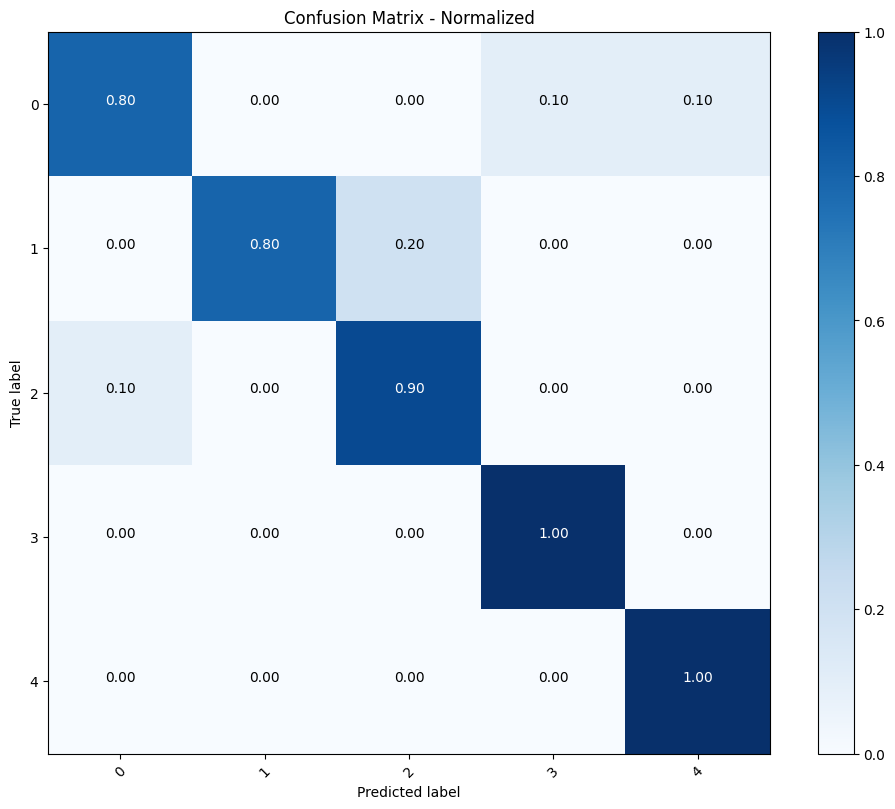

In [35]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=list(range(num_classes)),
                      title='Confusion Matrix - Without Normalization')
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=list(range(num_classes)),
                      normalize=True,
                      title='Confusion Matrix - Normalized')
plt.savefig('confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

In [36]:
# Classification report
print("\nRapport de classification:")
print("="*60)
print(classification_report(np.array(y_test), y_pred, target_names=[str(i) for i in range(num_classes)]))


Rapport de classification:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       1.00      0.80      0.89        10
           2       0.82      0.90      0.86        10
           3       0.91      1.00      0.95        10
           4       0.91      1.00      0.95        10

    accuracy                           0.90        50
   macro avg       0.91      0.90      0.90        50
weighted avg       0.91      0.90      0.90        50



## Step 10: Visualize Predictions

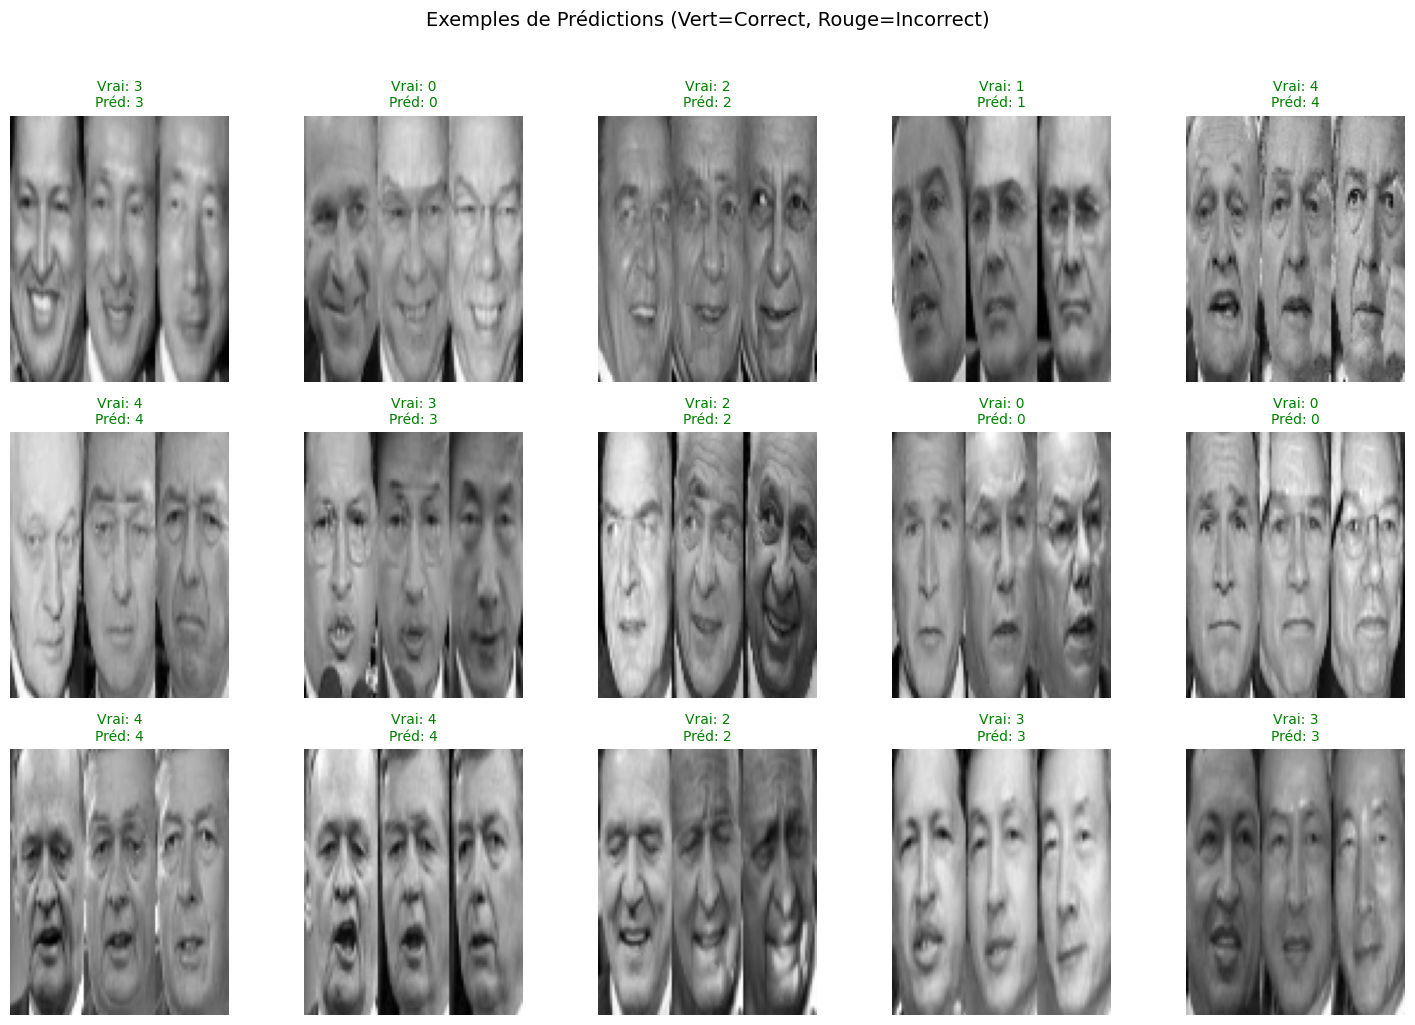

In [37]:
# Visualiser quelques prédictions
n_samples = 15
random_indices = np.random.choice(len(x_test), n_samples, replace=False)

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    axes[i].imshow(x_test[idx].reshape(im_rows, im_cols), cmap='gray')
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    
    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f"Vrai: {true_label}\nPréd: {pred_label}", color=color, fontsize=10)
    axes[i].axis('off')

plt.suptitle('Exemples de Prédictions (Vert=Correct, Rouge=Incorrect)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('predictions_examples.png', dpi=150, bbox_inches='tight')
plt.show()

Nombre d'erreurs: 5 sur 50 (10.00%)


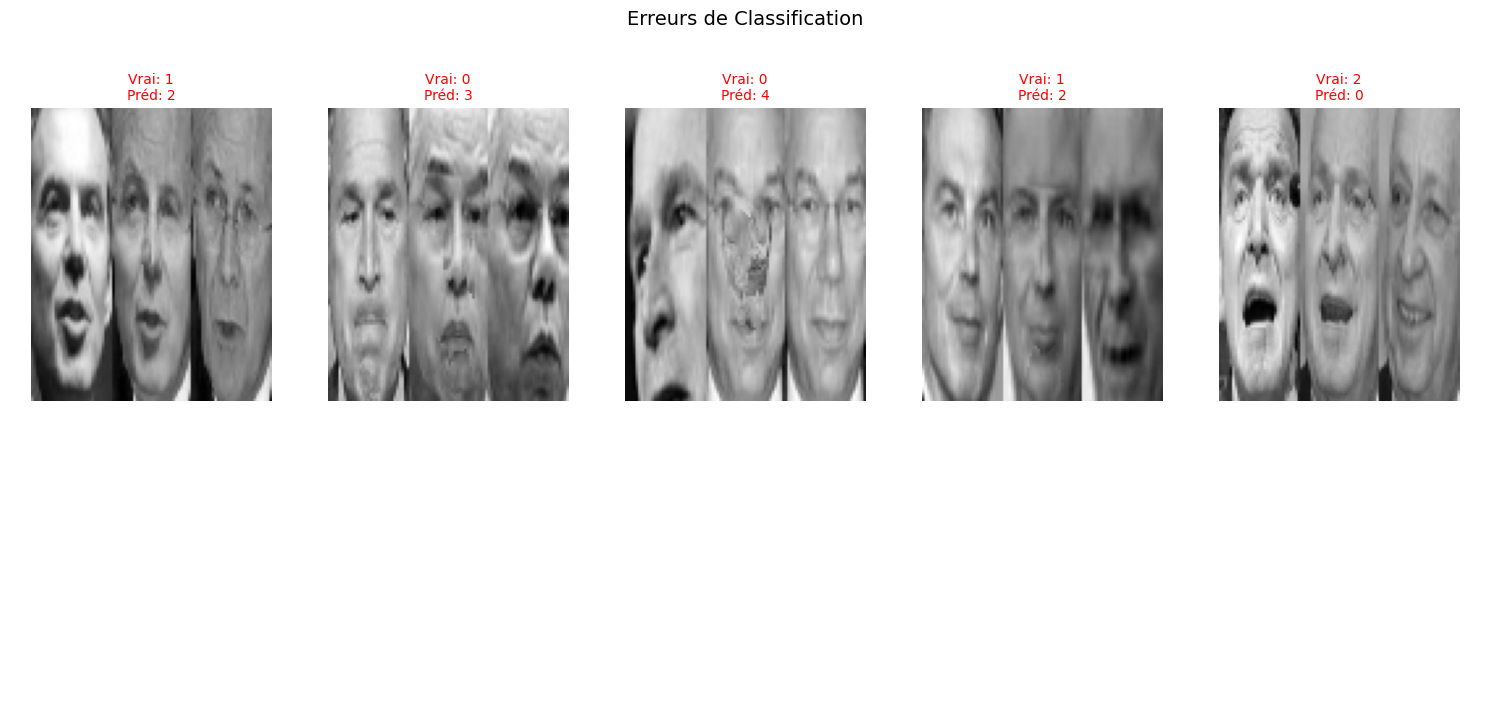

In [38]:
# Analyser les erreurs
errors_idx = np.where(y_test != y_pred)[0]
print(f"Nombre d'erreurs: {len(errors_idx)} sur {len(y_test)} ({100*len(errors_idx)/len(y_test):.2f}%)")

if len(errors_idx) > 0:
    n_errors = min(10, len(errors_idx))
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    axes = axes.flatten()
    
    for i, idx in enumerate(errors_idx[:n_errors]):
        axes[i].imshow(x_test[idx].reshape(im_rows, im_cols), cmap='gray')
        axes[i].set_title(f"Vrai: {y_test[idx]}\nPréd: {y_pred[idx]}", color='red', fontsize=10)
        axes[i].axis('off')
    
    for i in range(n_errors, 10):
        axes[i].axis('off')
    
    plt.suptitle('Erreurs de Classification', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig('classification_errors.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Aucune erreur de classification!")

## Step 11: Save Model

In [39]:
# Sauvegarder le modèle
cnn_model.save('cnn_face_recognition_model.keras')
print("Modèle sauvegardé: cnn_face_recognition_model.keras")

Modèle sauvegardé: cnn_face_recognition_model.keras


## Step 12: Summary

In [40]:
# Résumé final
print("\n" + "="*60)
print("RÉSUMÉ - RECONNAISSANCE FACIALE CNN")
print("="*60)
print(f"\nDataset:")
print(f"  - Source: {DATA_PATH}")
print(f"  - Nombre d'identités: {num_classes}")
print(f"  - Total images: {len(X)}")
print(f"  - Taille images: {im_rows}x{im_cols}")

print(f"\nSplit des données:")
print(f"  - Entraînement: {len(x_train)} images")
print(f"  - Validation: {len(x_valid)} images")
print(f"  - Test: {len(x_test)} images")

print(f"\nArchitecture (Kaggle):")
print(f"  - Conv2D(36, 7x7) -> MaxPool")
print(f"  - Conv2D(54, 5x5) -> MaxPool")
print(f"  - Dense(2024) -> Dropout(0.5)")
print(f"  - Dense(1024) -> Dropout(0.5)")
print(f"  - Dense(512) -> Dropout(0.5)")
print(f"  - Dense({num_classes}, softmax)")

print(f"\nHyperparamètres:")
print(f"  - Learning rate: 0.0001")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch size: {batch_size}")

print(f"\nPerformances sur le test:")
print(f"  - Accuracy: {acc*100:.2f}%")
print(f"  - Erreurs: {len(errors_idx)} / {len(y_test)}")
print("="*60)


RÉSUMÉ - RECONNAISSANCE FACIALE CNN

Dataset:
  - Source: C:\Users\marwa\OneDrive\Desktop\lfw_morph_comparison
  - Nombre d'identités: 5
  - Total images: 250
  - Taille images: 112x92

Split des données:
  - Entraînement: 190 images
  - Validation: 10 images
  - Test: 50 images

Architecture (Kaggle):
  - Conv2D(36, 7x7) -> MaxPool
  - Conv2D(54, 5x5) -> MaxPool
  - Dense(2024) -> Dropout(0.5)
  - Dense(1024) -> Dropout(0.5)
  - Dense(512) -> Dropout(0.5)
  - Dense(5, softmax)

Hyperparamètres:
  - Learning rate: 0.0001
  - Epochs: 250
  - Batch size: 512

Performances sur le test:
  - Accuracy: 90.00%
  - Erreurs: 5 / 50
